### Imports

In [1]:
import numpy as np 
import pandas as pd
import cv2

import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,InputLayer
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.applications import VGG19

import keras.layers as L

2024-05-02 17:53:20.915479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 17:53:20.915637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 17:53:21.093508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Reading Data

In [2]:
def read_images(path):
    images = []
    labels = []
    dirs = ['notumor','glioma','meningioma','pituitary']
    for i,dir_ in enumerate(dirs):
        path_ = f"{path}/{dir_}"
        for k in os.listdir(path_):
            images.append(cv2.imread(f"{path_}/{k}"))
            labels.append(dir_)
    return images,labels

In [3]:
train_images,train_labels = read_images(r"data/brain-tumor-mri-dataset/Training")
test_images,test_labels = read_images(r"data/brain-tumor-mri-dataset/Testing")

### EDA

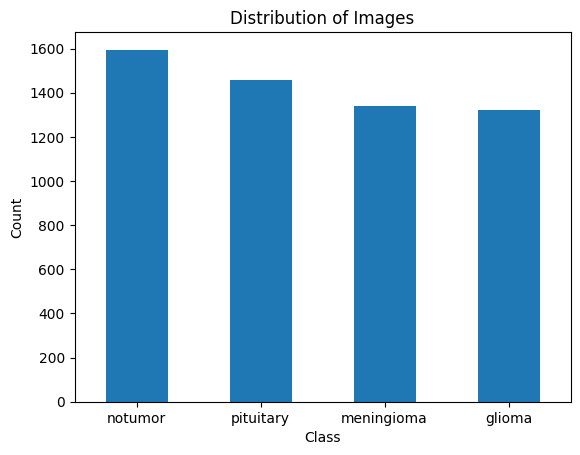

In [4]:
pd.DataFrame(train_labels,columns=["Class"])["Class"].value_counts().plot(kind='bar')
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Images")
plt.show()

### Data Preparation

In [5]:
IMG_SIZE =  (256,256)
for i in range(len(train_images)):
    train_images[i] = cv2.resize(train_images[i],IMG_SIZE)
for i in range(len(test_images)):
    test_images[i] = cv2.resize(test_images[i],IMG_SIZE)

In [6]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [7]:
encoder = OneHotEncoder(sparse_output=False)
train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1,1))

### ANN

In [8]:
model = Sequential()
model.add(InputLayer(shape=(256,256,3)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,170,212 (96.02 MB)

 Trainable params: 25,170,212 (96.02 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(train_images,train_labels_onehot,batch_size=32,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 291ms/step - accuracy: 0.4699 - loss: 1126.4657
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 318ms/step - accuracy: 0.7015 - loss: 151.1419
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 318ms/step - accuracy: 0.7292 - loss: 123.5437
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.7700 - loss: 94.5681
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.7776 - loss: 69.3528
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.8267 - loss: 43.5724
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.7808 - loss: 68.2220
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.8681 - loss: 25.3598
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.8415 - loss: 30.8502
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.8458 - loss: 29.6232


In [11]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(test_labels_onehot,axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [12]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.37      0.52       300
           1       0.36      0.96      0.53       306
           2       0.97      0.60      0.74       405
           3       0.99      0.42      0.59       300

    accuracy                           0.59      1311
   macro avg       0.80      0.59      0.59      1311
weighted avg       0.81      0.59      0.61      1311



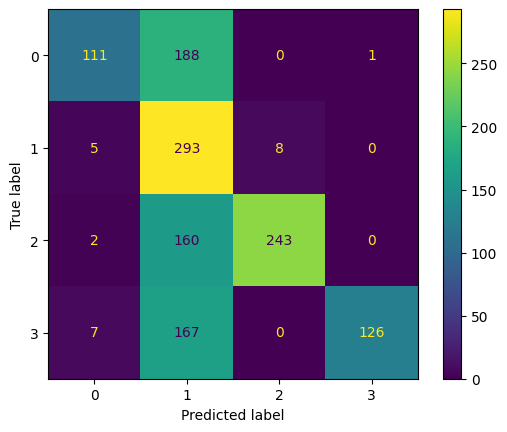

In [13]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot()
plt.show()

### CNN

In [14]:
model = Sequential([
    InputLayer(shape=(256,256,3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,518,084 (120.23 MB)

 Trainable params: 31,518,084 (120.23 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.fit(train_images,train_labels_onehot,batch_size=32,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.6509 - loss: 77.9189
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9433 - loss: 0.1827
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9856 - loss: 0.0478
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9906 - loss: 0.0349
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9830 - loss: 0.0607
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9933 - loss: 0.0232
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9844 - loss: 0.0774
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9950 - loss: 0.0214
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9923 - loss: 0.0285
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9951 - loss: 0.0149


In [16]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(test_labels_onehot,axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step


In [17]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       300
           1       0.87      0.92      0.89       306
           2       0.98      1.00      0.99       405
           3       0.95      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



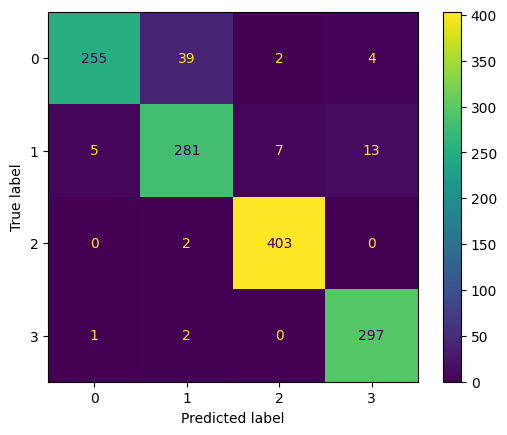

In [18]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot()
plt.show()


### Transfer Learning using VGG19 Imagenet

In [19]:
model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
model_vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model = Sequential()
for layer in model_vgg19.layers:
    model.add(layer)

In [22]:
for i in model.layers:
   i.trainable = False

In [23]:
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(4,activation='softmax'))

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images,train_labels_onehot,batch_size=32,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2685s 15s/step - accuracy: 0.7620 - loss: 8.8179
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2690s 15s/step - accuracy: 0.9556 - loss: 0.2623
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2686s 15s/step - accuracy: 0.9722 - loss: 0.1397
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2701s 15s/step - accuracy: 0.9917 - loss: 0.0273
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2714s 15s/step - accuracy: 0.9899 - loss: 0.0447
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2655s 15s/step - accuracy: 0.9905 - loss: 0.0451
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2643s 15s/step - accuracy: 0.9867 - loss: 0.0814
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2644s 15s/step - accuracy: 0.9900 - loss: 0.0372
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2621s 15s/step - accuracy: 0.9816 - loss: 0.0848
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2667s 15s/step - accuracy: 0.9913 - loss: 0.0524


In [25]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(test_labels_onehot,axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 597s 15s/step


In [26]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       300
           1       0.91      0.95      0.93       306
           2       1.00      1.00      1.00       405
           3       0.98      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



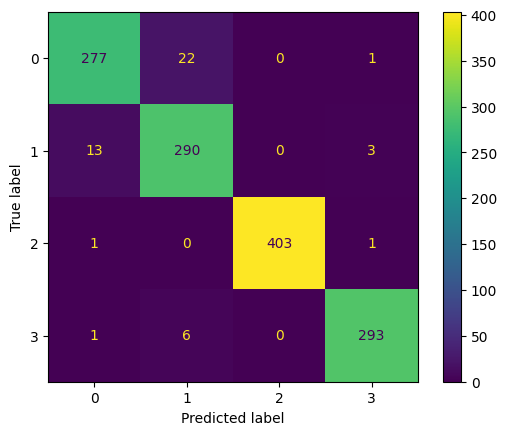

In [27]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot()
plt.show()


### Vision Transformer

In [28]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 1
n_classes=4
image_size = 256
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

In [29]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [30]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [31]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [32]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(n_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [33]:
decay_steps = len(train_images) // 32
initial_learning_rate = learning_rate

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])


model.fit(train_images,train_labels_onehot,
          epochs = num_epochs,
          batch_size=32)

179/179 ━━━━━━━━━━━━━━━━━━━━ 3409s 19s/step - accuracy: 0.2350 - loss: 5.7833
